In [4]:

import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import arviz as az


In [ ]:
az.style.use('arviz-darkgrid')

data = pd.read_csv("date_alegeri_turul2.csv")

X1 = data['Varsta'].values
X2 = data['Sex'].values
X3 = data['Educatie'].values
X4 = data['Venit'].values
y = data['Vot'].values

X1_norm = (X1 - np.mean(X1)) / np.std(X1)
X2_norm = (X2 - np.mean(X2)) / np.std(X2)
X3_norm = (X3 - np.mean(X3)) / np.std(X3)
X4_norm = (X3 - np.mean(X4)) / np.std(X4)
y_norm = (y - np.mean(y)) / np.std(y)

results = {}

with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    beta3 = pm.Normal("beta3", mu=0, sigma=10)
    beta4 = pm.Normal("beta4", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + beta1 * X1_norm + beta2 * X2_norm + beta3 * X3_norm + beta4 * X4_norm

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_norm)

    trace = pm.sample(1000, tune=500, return_inferencedata=True)

    # idata = pm.sample(1000, return_inferencedata=True, log_likelihood=True)
    # pm.compute_log_likelihood(idata,model=model)
    # waic = az.waic(idata)
    # loo = az.loo(idata)

    # # waic_l = az.waic(idata_l, scale="deviance")

    # results[0] = {
    #         "idata": idata,
    #         "waic": waic,
    #         "loo": loo,
    #         "α_post": idata.posterior['α'].mean(("chain", "draw")).values,
    #         "β_post": idata.posterior['β'].mean(("chain", "draw")).values
    # }

Output()

In [6]:
mean_X1, std_X1 = np.mean(X1), np.std(X1)
mean_X2, std_X2 = np.mean(X2), np.std(X2)
mean_X3, std_X3 = np.mean(X3), np.std(X3)
mean_X4, std_X4 = np.mean(X4), np.std(X4)
mean_y, std_y = np.mean(y), np.std(y)

beta1_norm = trace.posterior['beta1'].mean().item()
beta2_norm = trace.posterior['beta2'].mean().item()
beta3_norm = trace.posterior['beta3'].mean().item()
beta4_norm = trace.posterior['beta4'].mean().item()
intercept_norm = trace.posterior['intercept'].mean().item()

beta1_original = beta1_norm * std_X1 + mean_X1
beta2_original = beta2_norm * std_X2 + mean_X2
beta3_original = beta3_norm * std_X3 + mean_X3
beta4_original = beta4_norm * std_X4 + mean_X4

intercept_original = (
    intercept_norm * std_y
    + mean_y
    - (beta1_original * mean_X1 + beta2_original * mean_X2 + beta3_original * mean_X3 + beta4_original * mean_X4)
)


Coeficienti in unitati originale:
Coeficientul pentru varsta: 41.05
Coeficientul pentru sex: 0.40
Coeficientul educatie: 1.15
Coeficientul venit: 6.10
Intercept: -1683.78


array([[<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'intercept'}>, <Axes: >]], dtype=object)

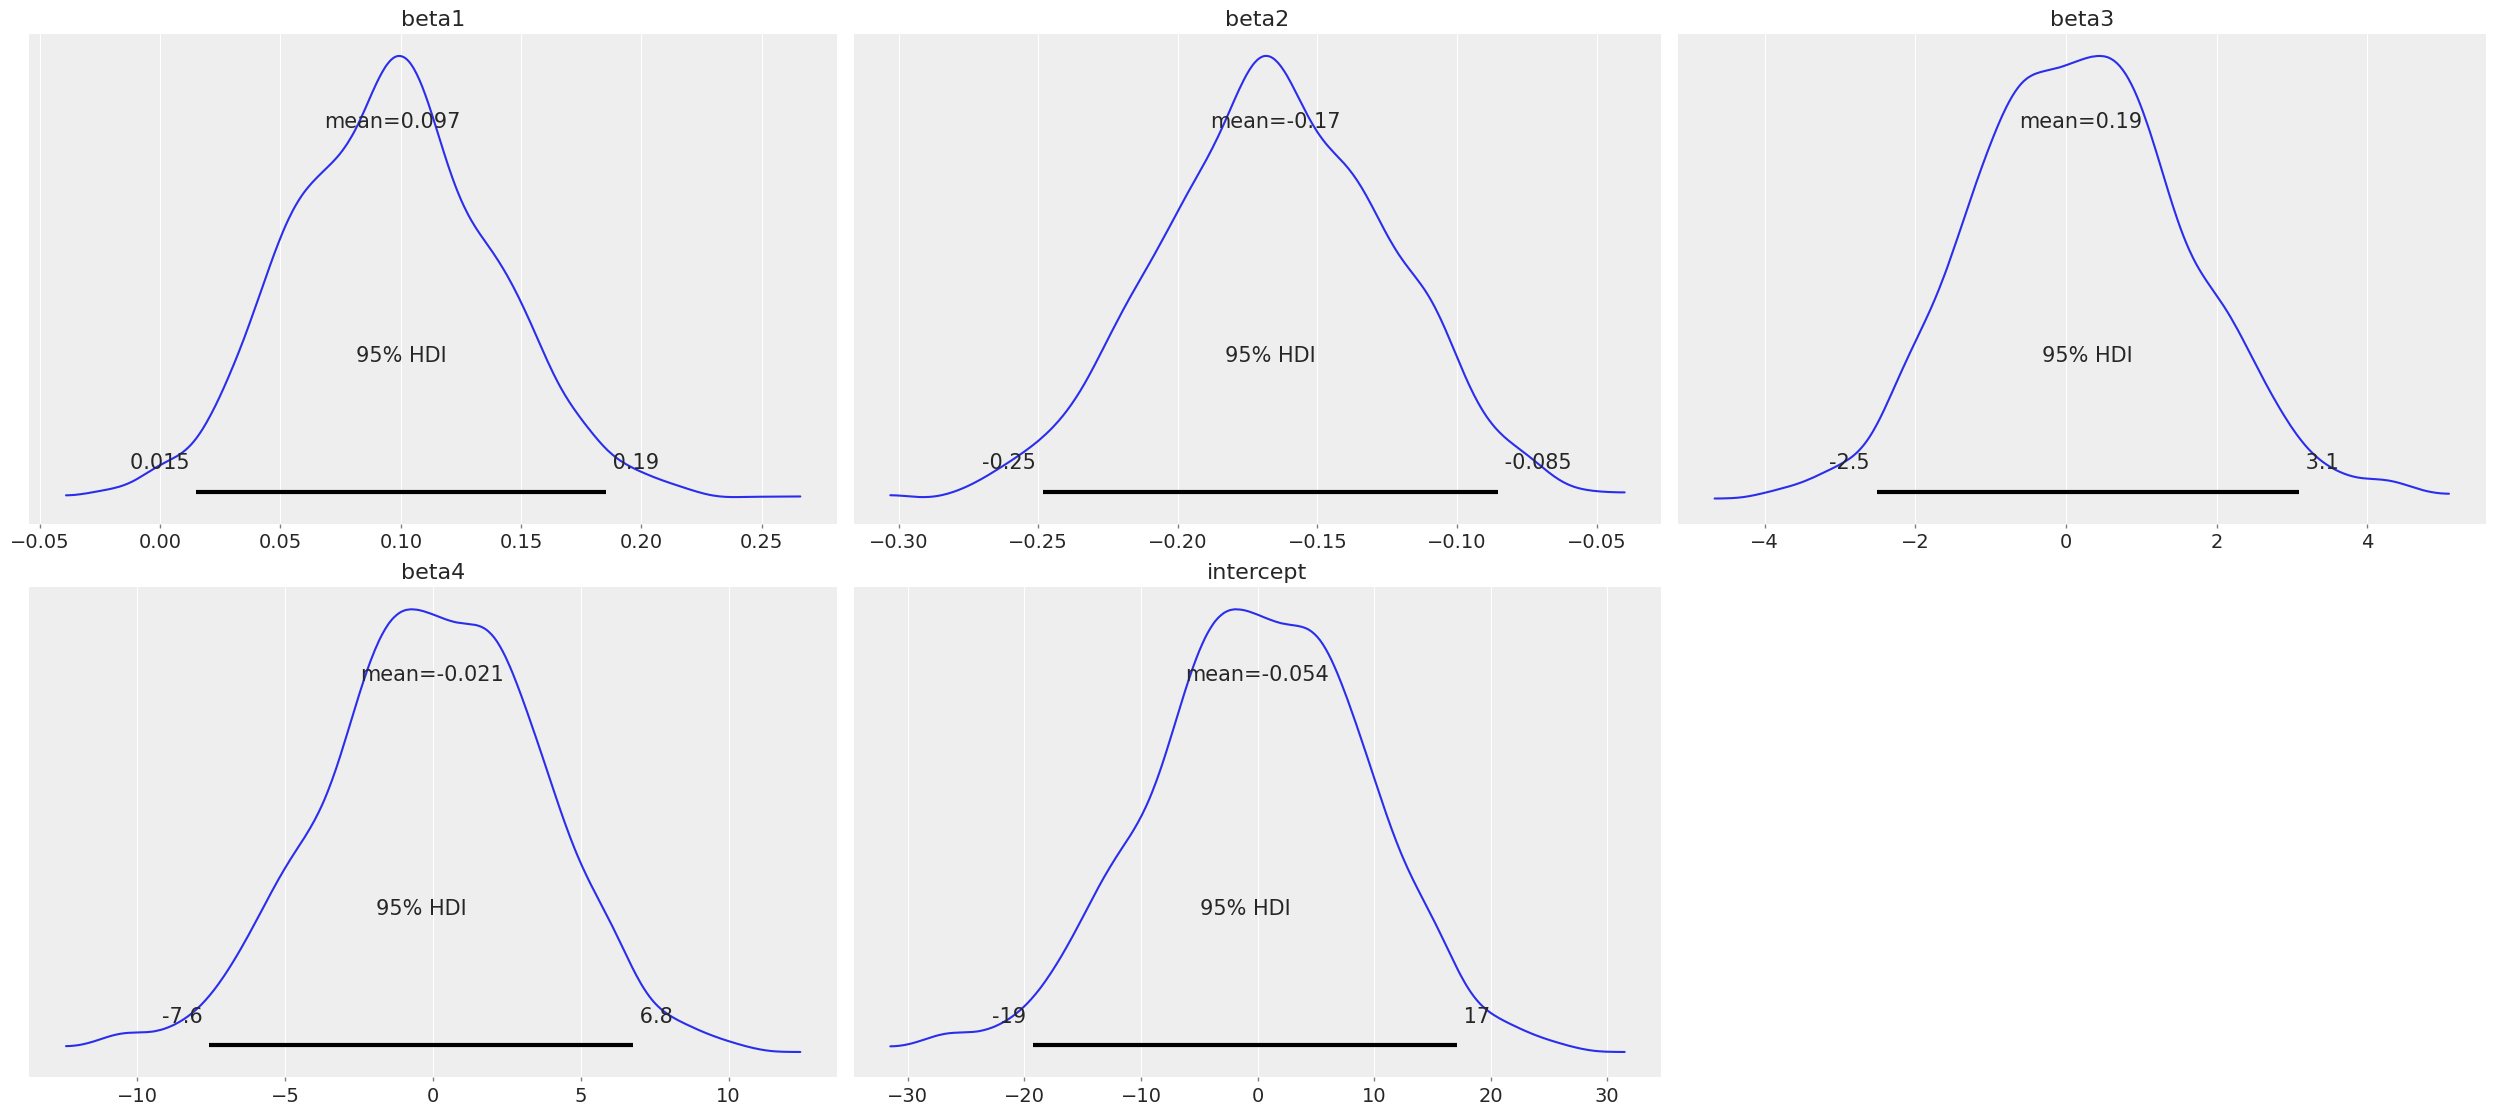

In [7]:
print("\nCoeficienti in unitati originale:")
print(f"Coeficientul pentru varsta: {beta1_original:.2f}")
print(f"Coeficientul pentru sex: {beta2_original:.2f}")
print(f"Coeficientul educatie: {beta3_original:.2f}")
print(f"Coeficientul venit: {beta4_original:.2f}")
print(f"Intercept: {intercept_original:.2f}")

az.plot_posterior(trace, var_names=["beta1", "beta2", "beta3", "beta4", "intercept"], hdi_prob=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


              mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_varsta  0.513  1.392    -1.889      3.749      0.109    0.077     171.0   
beta_venit  -0.110  3.530    -8.211      6.036      0.276    0.198     171.0   
intercept    1.132  8.951   -19.447     16.769      0.700    0.513     171.0   
p[0]         0.693  0.034     0.625      0.755      0.001    0.001    1699.0   
p[1]         0.803  0.018     0.768      0.837      0.000    0.000    2219.0   
...            ...    ...       ...        ...        ...      ...       ...   
p[495]       0.879  0.023     0.834      0.921      0.001    0.000    1422.0   
p[496]       0.803  0.018     0.768      0.837      0.000    0.000    2219.0   
p[497]       0.803  0.018     0.768      0.837      0.000    0.000    2219.0   
p[498]       0.879  0.023     0.834      0.921      0.001    0.000    1422.0   
p[499]       0.879  0.023     0.834      0.921      0.001    0.000    1422.0   

             ess_tail  r_hat  
beta_var

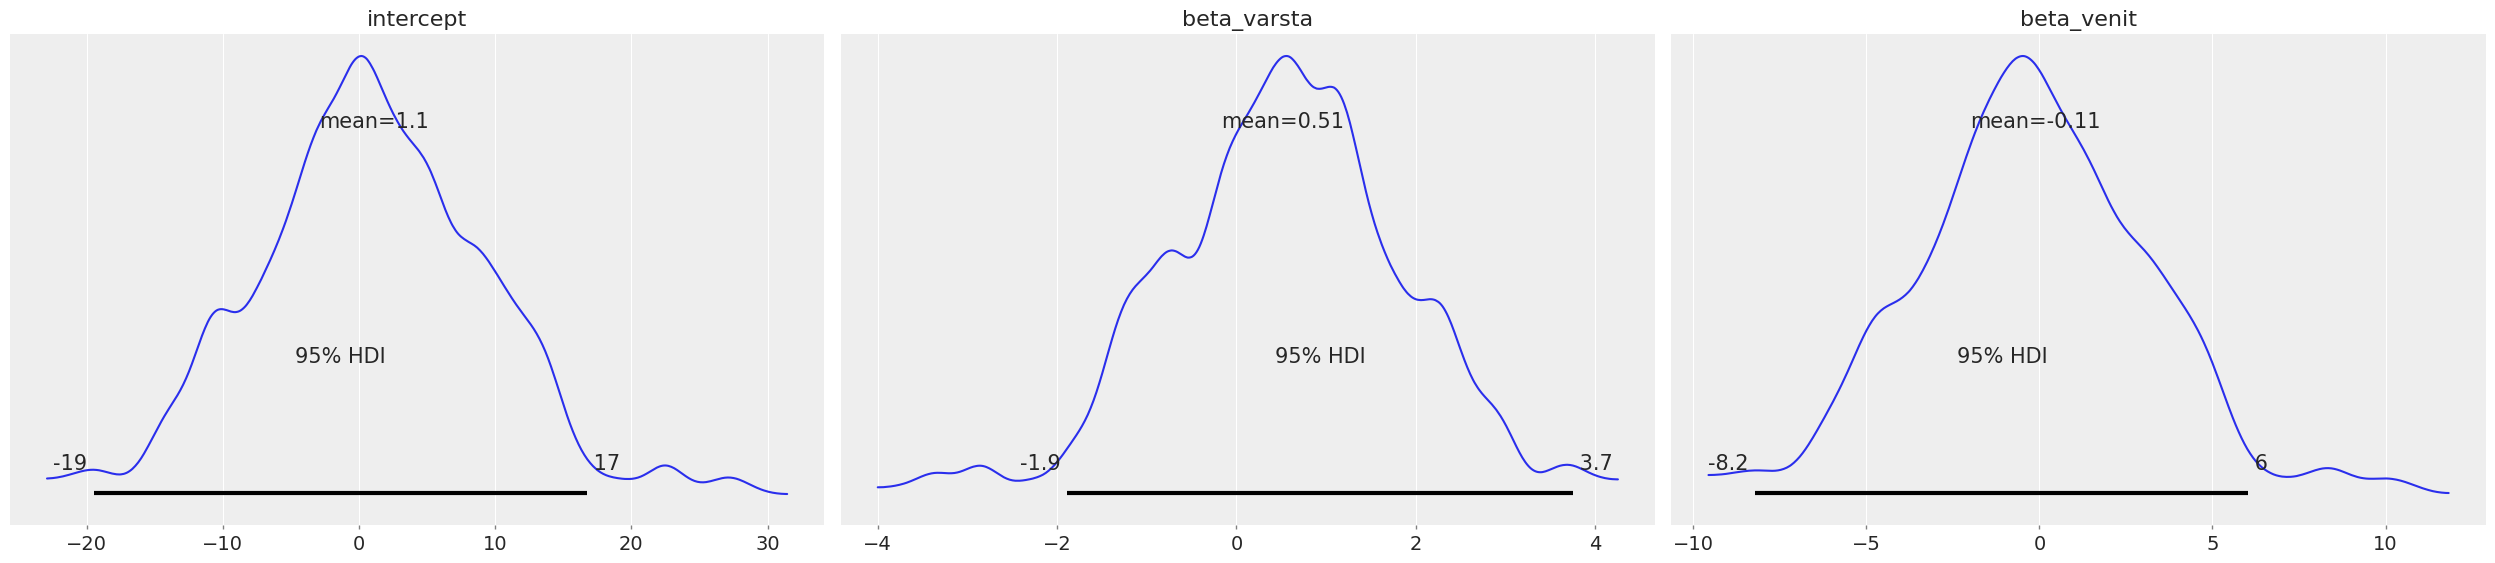

In [10]:
passed = data['Vot'].values

with pm.Model() as logistic_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta_varsta = pm.Normal("beta_varsta", mu=0, sigma=10)
    beta_venit = pm.Normal("beta_venit", mu=0, sigma=10)

    logit_p = intercept + beta_varsta * X3_norm + beta_venit * X4_norm

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=passed)

    trace = pm.sample(1000, tune=500, target_accept=0.9, return_inferencedata=True)

    # idata = pm.sample(1000, return_inferencedata=True, log_likelihood=True)
    # pm.compute_log_likelihood(idata,model=model)
    # waic = az.waic(idata)
    # loo = az.loo(idata)

    # # waic_l = az.waic(idata_l, scale="deviance")

    # results[1] = {
    #         "idata": idata,
    #         "waic": waic,
    #         "loo": loo,
    #         "α_post": idata.posterior['α'].mean(("chain", "draw")).values,
    #         "β_post": idata.posterior['β'].mean(("chain", "draw")).values
    # }

print(az.summary(trace, hdi_prob=0.95))

az.plot_posterior(trace, var_names=["intercept", "beta_varsta", "beta_venit"], hdi_prob=0.95)
plt.show()


Coeficientul interceptului (intercept): 1.1319743632686368
Coeficient pentru varsta (beta_varsta): 0.5131687028925035
Coeficient pentru venit (beta_venit): -0.11029274018300189


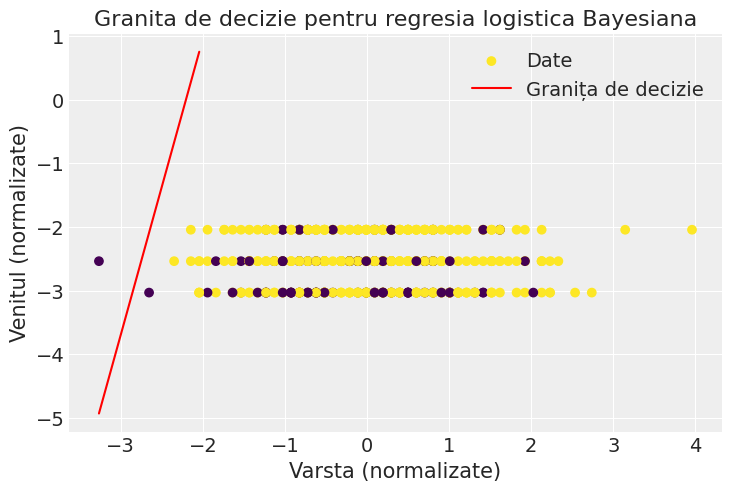

In [14]:
mean_intercept = trace.posterior['intercept'].mean().item()
mean_beta_varsta = trace.posterior['beta_varsta'].mean().item()
mean_beta_venit = trace.posterior['beta_venit'].mean().item()

print("\nCoeficientul interceptului (intercept):", mean_intercept)
print("Coeficient pentru varsta (beta_varsta):", mean_beta_varsta)
print("Coeficient pentru venit (beta_venit):", mean_beta_venit)

def decision_boundary(x):
    return -(mean_intercept + mean_beta_varsta * x) / mean_beta_venit

plt.scatter(X1_norm, X4_norm, c=passed, cmap='viridis', label="Date")
x_vals = np.linspace(min(X1_norm), max(X4_norm), 100)
plt.plot(x_vals, decision_boundary(x_vals), color='red', label="Granița de decizie")
plt.xlabel("Varsta (normalizate)")
plt.ylabel("Venitul (normalizate)")
plt.legend()
plt.title("Granita de decizie pentru regresia logistica Bayesiana")
plt.show()